In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, precision_recall_curve, confusion_matrix,
                             classification_report, average_precision_score)
from sklearn.preprocessing import LabelEncoder
from itertools import cycle


In [3]:
df = pd.read_csv('/content/drive/MyDrive/merged_V2.csv')

In [4]:
# EMA를 적용할 좌표 열 리스트
coordinate_columns = [col for col in df.columns if '_x' in col or '_y' in col]

# EMA 계산 함수
def apply_ema(df, window_size):
    return df.ewm(span=window_size, adjust=False).mean()

# window size 설정 (예: 10 프레임)
window_size = 10

# 각 좌표 열에 대해 EMA 적용
for col in coordinate_columns:
    df[f"{col}_EMA"] = apply_ema(df[col], window_size)

df.head()

,image_filename,Nose_x,Nose_y,LEye_x,LEye_y,REye_x,REye_y,LEar_x,LEar_y,REar_x,...,RBigToe_x_EMA,RBigToe_y_EMA,LSmallToe_x_EMA,LSmallToe_y_EMA,RSmallToe_x_EMA,RSmallToe_y_EMA,LHeel_x_EMA,LHeel_y_EMA,RHeel_x_EMA,RHeel_y_EMA
0,0.jpg,1368.317139,245.318161,1375.947510,242.774719,1368.317139,240.231262,1388.664673,245.318161,1386.121338,...,1355.599976,466.598053,1360.686768,466.598053,1355.599976,464.054596,1383.577881,456.424255,1386.121338,456.424255
1,1.jpg,1367.379517,245.956863,1375.112671,240.801453,1367.379517,240.801453,1388.001221,245.956863,1385.423462,...,1355.398338,466.318701,1360.497625,466.787373,1355.398338,463.769012,1383.913441,456.588662,1385.994451,456.588662
2,2.jpg,1365.833862,248.601212,1373.505005,243.487152,1365.833862,243.487152,1386.290161,246.044174,1383.733032,...,1355.436064,466.251394,1360.073119,466.634854,1355.436064,463.700370,1383.415729,456.895712,1386.513127,456.430796
3,3.jpg,1365.026855,247.695007,1372.763184,242.537491,1365.026855,242.537491,1385.656982,247.695007,1380.499390,...,1355.304401,466.367369,1360.036077,466.681108,1355.304401,463.811306,1382.885486,457.306125,1386.826325,456.456878
4,4.jpg,1362.091553,247.426620,1369.815674,242.277222,1364.666260,239.702530,1382.689209,247.426620,1380.114502,...,1355.134043,466.350767,1359.941671,466.607463,1355.134043,463.791320,1383.786056,457.532642,1387.010380,456.369676


In [5]:
df = df.drop(['image_filename', 'Nose_x', 'Nose_y', 'LEye_x', 'LEye_y', 'REye_x', 'REye_y', 'LEar_x', 'LEar_y', 'REar_x', 'REar_y', 'LShoulder_x', 'LShoulder_y', 'RShoulder_x', 'RShoulder_y', 'LElbow_x', 'LElbow_y', 'RElbow_x', 'RElbow_y', 'LWrist_x', 'LWrist_y', 'RWrist_x', 'RWrist_y', 'LHip_x', 'LHip_y', 'RHip_x', 'RHip_y', 'LKnee_x', 'LKnee_y', 'RKnee_x', 'RKnee_y', 'LAnkle_x', 'LAnkle_y', 'RAnkle_x', 'RAnkle_y', 'Head_x', 'Head_y', 'Neck_x', 'Neck_y', 'Hip_x', 'Hip_y', 'LBigToe_x', 'LBigToe_y', 'RBigToe_x', 'RBigToe_y', 'LSmallToe_x', 'LSmallToe_y', 'RSmallToe_x', 'RSmallToe_y', 'LHeel_x', 'LHeel_y', 'RHeel_x', 'RHeel_y', 'gender', 'level','path'], axis=1)

In [6]:
encoder = LabelEncoder()
encoder.fit(df['label'])

df["label"] = encoder.transform(df['label'])
df
# 0 = jump, 1 = spin, 2 = step

,label,Nose_x_EMA,Nose_y_EMA,LEye_x_EMA,LEye_y_EMA,REye_x_EMA,REye_y_EMA,LEar_x_EMA,LEar_y_EMA,REar_x_EMA,...,RBigToe_x_EMA,RBigToe_y_EMA,LSmallToe_x_EMA,LSmallToe_y_EMA,RSmallToe_x_EMA,RSmallToe_y_EMA,LHeel_x_EMA,LHeel_y_EMA,RHeel_x_EMA,RHeel_y_EMA
0,0,1368.317139,245.318161,1375.947510,242.774719,1368.317139,240.231262,1388.664673,245.318161,1386.121338,...,1355.599976,466.598053,1360.686768,466.598053,1355.599976,464.054596,1383.577881,456.424255,1386.121338,456.424255
1,0,1368.146662,245.434289,1375.795721,242.415943,1368.146662,240.334933,1388.544045,245.434289,1385.994451,...,1355.398338,466.318701,1360.497625,466.787373,1355.398338,463.769012,1383.913441,456.588662,1385.994451,456.588662
2,0,1367.726153,246.010093,1375.379227,242.610709,1367.726153,240.908064,1388.134248,245.545177,1385.583284,...,1355.436064,466.251394,1360.073119,466.634854,1355.436064,463.700370,1383.415729,456.895712,1386.513127,456.430796
3,0,1367.235372,246.316441,1374.903583,242.597396,1367.235372,241.204323,1387.683836,245.936055,1384.658940,...,1355.304401,466.367369,1360.036077,466.681108,1355.304401,463.811306,1382.885486,457.306125,1386.826325,456.456878
4,0,1366.300132,246.518292,1373.978508,242.539183,1366.768260,240.931270,1386.775722,246.207067,1383.832678,...,1355.134043,466.350767,1359.941671,466.607463,1355.134043,463.791320,1383.786056,457.532642,1387.010380,456.369676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196118,2,584.706751,484.468800,594.076186,474.215096,578.759124,475.394052,616.783612,472.412332,575.380146,...,603.185642,838.314176,635.667088,841.863029,594.293374,832.302293,653.038744,810.307695,621.964271,808.800231
10196119,2,579.157663,487.584541,589.187711,477.619053,573.503370,478.583653,611.706755,475.356012,569.950699,...,596.640903,844.078553,629.521019,848.558265,587.789305,837.583646,647.674433,816.435866,616.733529,813.626392
10196120,2,573.810305,490.880649,584.372132,481.156783,567.613775,481.946002,606.722519,478.520059,563.921899,...,590.470198,849.294750,623.653261,855.315394,581.657692,843.195590,642.431770,822.752292,611.620479,818.883341
10196121,2,568.927547,494.943276,579.121899,484.658101,562.304803,486.080254,602.067138,481.724353,558.507754,...,584.111226,854.187460,617.472419,862.219143,575.348137,848.420804,636.718789,829.365190,606.074559,824.646828


In [7]:
import numpy as np

def add_adversarial_noise_optimized(df, epsilon=2.0):
    # 필요한 컬럼 리스트
    ema_columns = [col for col in df.columns if col.endswith("_EMA") and ('_x' in col or '_y' in col)]
    # 원본 복사는 최소한으로 (필요한 부분만 복사)
    df_adv = df.copy(deep=False)  # 얕은 복사: 메모리 사용량이 줄어듦 (단, 내부 데이터가 수정되면 원본에도 영향이 있을 수 있음)

    # 모든 eMA 컬럼에 대해 한 번에 noise 행렬 생성 후 적용
    noise = np.random.uniform(-epsilon, epsilon, size=(df_adv.shape[0], len(ema_columns)))
    df_adv.loc[:, ema_columns] = df_adv.loc[:, ema_columns] + noise
    return df_adv

# 최적화된 함수 사용
df_adv = add_adversarial_noise_optimized(df, epsilon=2.0)

In [8]:
df.head()

,label,Nose_x_EMA,Nose_y_EMA,LEye_x_EMA,LEye_y_EMA,REye_x_EMA,REye_y_EMA,LEar_x_EMA,LEar_y_EMA,REar_x_EMA,...,RBigToe_x_EMA,RBigToe_y_EMA,LSmallToe_x_EMA,LSmallToe_y_EMA,RSmallToe_x_EMA,RSmallToe_y_EMA,LHeel_x_EMA,LHeel_y_EMA,RHeel_x_EMA,RHeel_y_EMA
0,0,1367.752774,246.741787,1377.827563,241.299151,1367.522209,240.048582,1386.737851,244.166735,1387.618234,...,1355.920563,467.181861,1360.493784,464.744589,1355.847409,465.610518,1385.294421,454.569296,1386.229303,458.191860
1,0,1367.630706,244.908000,1374.206825,241.953552,1368.236357,241.087955,1386.558393,247.049094,1384.793683,...,1353.785521,464.878911,1358.783012,468.456927,1353.777212,464.802881,1383.761527,455.025918,1384.675201,455.730589
2,0,1367.222446,247.483169,1376.649294,242.879364,1367.949070,239.132785,1389.437853,246.148656,1384.177483,...,1355.142868,467.916055,1359.067099,465.963795,1356.897124,463.253472,1382.195903,458.476053,1386.866229,456.737412
3,0,1365.929483,245.733357,1374.267371,242.796679,1369.210034,242.275914,1386.935531,247.769692,1382.757441,...,1354.523421,465.237046,1359.381724,468.661686,1355.756597,464.944793,1383.408906,457.757800,1384.859832,457.045149
4,0,1366.135836,244.943396,1373.929393,241.363956,1366.250517,241.601665,1387.869774,246.416479,1384.759397,...,1356.091158,465.740499,1358.469463,466.001999,1354.285370,464.774989,1384.317949,458.471841,1388.647233,457.163593


In [9]:
X = df.drop(['label'], axis=1)
Y = df['label']

print(X.shape)
print(Y.shape)

(10196123, 52)
(10196123,)


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y, test_size=0.2, random_state=42, stratify = Y
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42, stratify=Y_train
)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(6525518, 52)
(2039225, 52)
(6525518,)
(2039225,)
(1631380, 52)
(1631380,)


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import numpy as np

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=False)

X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.long)

print(f"Total dataset size: {X_tensor.shape}")
print(f"Using {n_splits}-fold cross-validation")

Total dataset size: torch.Size([10196123, 52])
Using 5-fold cross-validation


In [12]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [13]:
def dataloader(X_train, Y_train, X_val, Y_val, batch_size=64):
    train_dataset = CustomDataset(X_train, Y_train)
    val_dataset = CustomDataset(X_val, Y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))  # (batch, seq_len=1, features)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return out


In [15]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_classes, num_heads=4, hidden_dim=128, num_layers=2):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=num_heads, dim_feedforward=hidden_dim)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = self.transformer_encoder(x.unsqueeze(1))  # (batch, seq_len=1, features)
        x = self.fc(x[:, -1, :])  # 마지막 타임스텝의 출력 사용
        return x


In [16]:
def train_model(model, train_loader, val_loader, epochs=10, learning_rate=1e-4, device="cuda"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct, total = 0, 0

        # Training loop
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == Y_batch).sum().item()
            total += Y_batch.size(0)

        train_acc = correct / total

        # Validation loop
        model.eval()  # 평가 모드 전환
        val_loss = 0
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == Y_batch).sum().item()
                total_val += Y_batch.size(0)

        val_acc = correct_val / total_val

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}")

    return model


def get_predictions(model, test_loader, device="cuda"):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)  # 확률로 변환
            all_probs.append(probs.cpu().numpy())
    return np.concatenate(all_probs, axis=0)




In [17]:
# Test Set을 NumPy 배열로 변환 후 PyTorch Tensor로 변환
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

# Test Dataset & DataLoader 생성
test_dataset = CustomDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Test set size: {len(test_dataset)} samples")

Test set size: 2039225 samples


In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(np.unique(Y))  # 클래스 개수
input_size = X.shape[1]  # 입력 특성 개수

# 테스트셋 샘플 수와 클래스 수를 이용해 예측 확률 누적 배열 생성
ensemble_lstm_probs = np.zeros((len(test_dataset), num_classes))
ensemble_transformer_probs = np.zeros((len(test_dataset), num_classes))


# K-Fold 학습 및 각 fold 모델의 예측값 누적
for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor, Y_tensor)):
    print(f" Fold {fold+1}/{n_splits}")

    # 데이터 분할
    X_train_fold, Y_train_fold = X_tensor[train_idx], Y_tensor[train_idx]
    X_val_fold, Y_val_fold = X_tensor[val_idx], Y_tensor[val_idx]

    train_loader, val_loader = dataloader(X_train_fold, Y_train_fold, X_val_fold, Y_val_fold, batch_size=32)

    # LSTM 모델 학습
    lstm_model = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, num_classes=num_classes)
    print(" Training LSTM Model")
    trained_lstm = train_model(lstm_model, train_loader, val_loader, epochs=7, device=device)

    # Transformer 모델 학습
    transformer_model = TransformerModel(input_size=input_size, num_classes=num_classes, num_heads=4, hidden_dim=128, num_layers=2)
    print(" Training Transformer Model")
    trained_transformer = train_model(transformer_model, train_loader, val_loader, epochs=7, device=device)

    # 각 fold의 모델로 테스트셋 예측 (확률)
    lstm_fold_probs = get_predictions(trained_lstm, test_loader, device=device)
    transformer_fold_probs = get_predictions(trained_transformer, test_loader, device=device)

    # 각 fold의 예측값을 누적 (앙상블을 위해)
    ensemble_lstm_probs += lstm_fold_probs
    ensemble_transformer_probs += transformer_fold_probs



 Fold 1/5
 Training LSTM Model
Epoch 1/7, Train Loss: 1.0206, Train Acc: 0.4821, Val Loss: 0.9959, Val Acc: 0.4984
Epoch 2/7, Train Loss: 1.0131, Train Acc: 0.4879, Val Loss: 0.9963, Val Acc: 0.4804
Epoch 3/7, Train Loss: 1.0084, Train Acc: 0.4924, Val Loss: 1.0140, Val Acc: 0.4936
Epoch 4/7, Train Loss: 1.0121, Train Acc: 0.4935, Val Loss: 1.0174, Val Acc: 0.4935
Epoch 5/7, Train Loss: 1.0110, Train Acc: 0.4957, Val Loss: 1.0168, Val Acc: 0.5015
Epoch 6/7, Train Loss: 1.0090, Train Acc: 0.4981, Val Loss: 1.0187, Val Acc: 0.4791
Epoch 7/7, Train Loss: 1.0076, Train Acc: 0.5001, Val Loss: 1.0224, Val Acc: 0.4941
 Training Transformer Model


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/7, Train Loss: 0.8704, Train Acc: 0.5926, Val Loss: 0.9707, Val Acc: 0.5352
Epoch 2/7, Train Loss: 0.7565, Train Acc: 0.6592, Val Loss: 0.9039, Val Acc: 0.5943
Epoch 3/7, Train Loss: 0.7064, Train Acc: 0.6856, Val Loss: 0.8790, Val Acc: 0.6038
Epoch 4/7, Train Loss: 0.6741, Train Acc: 0.7026, Val Loss: 0.9114, Val Acc: 0.5770
Epoch 5/7, Train Loss: 0.6532, Train Acc: 0.7132, Val Loss: 0.9063, Val Acc: 0.5829
Epoch 6/7, Train Loss: 0.6366, Train Acc: 0.7219, Val Loss: 0.9551, Val Acc: 0.5552
Epoch 7/7, Train Loss: 0.6283, Train Acc: 0.7260, Val Loss: 0.9478, Val Acc: 0.5608
 Fold 2/5
 Training LSTM Model
Epoch 1/7, Train Loss: 1.0066, Train Acc: 0.4928, Val Loss: 1.0185, Val Acc: 0.5115
Epoch 2/7, Train Loss: 1.0071, Train Acc: 0.4908, Val Loss: 1.0256, Val Acc: 0.4856
Epoch 3/7, Train Loss: 1.0053, Train Acc: 0.4935, Val Loss: 1.0186, Val Acc: 0.5012
Epoch 4/7, Train Loss: 1.0029, Train Acc: 0.4973, Val Loss: 1.0157, Val Acc: 0.4930
Epoch 5/7, Train Loss: 1.0004, Train Acc: 0.4

In [19]:
# 각 모델의 예측 확률을 평균 내어 최종 예측값 도출
ensemble_lstm_probs /= n_splits
ensemble_transformer_probs /= n_splits

# 예측 확률에서 최종 클래스 라벨 도출 (argmax)
ensemble_lstm_preds = np.argmax(ensemble_lstm_probs, axis=1)
ensemble_transformer_preds = np.argmax(ensemble_transformer_probs, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print("=== LSTM Ensemble Evaluation ===")
print("Classification Report:")
print(classification_report(Y_test.values, ensemble_lstm_preds))
print("Confusion Matrix:")
print(confusion_matrix(Y_test.values, ensemble_lstm_preds))

print("\n=== Transformer Ensemble Evaluation ===")
print("Classification Report:")
print(classification_report(Y_test.values, ensemble_transformer_preds))
print("Confusion Matrix:")
print(confusion_matrix(Y_test.values, ensemble_transformer_preds))


=== LSTM Ensemble Evaluation ===
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.66      0.62    921106
           1       0.43      0.65      0.52    656960
           2       0.89      0.00      0.00    461159

    accuracy                           0.51   2039225
   macro avg       0.64      0.44      0.38   2039225
weighted avg       0.60      0.51      0.45   2039225

Confusion Matrix:
[[607542 313562      2]
 [228116 428842      2]
 [201493 259632     34]]

=== Transformer Ensemble Evaluation ===
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80    921106
           1       0.77      0.70      0.73    656960
           2       0.73      0.63      0.68    461159

    accuracy                           0.75   2039225
   macro avg       0.75      0.73      0.74   2039225
weighted avg       0.75      0.75      0.75   2039225

Confusion Matrix:
[[790269 

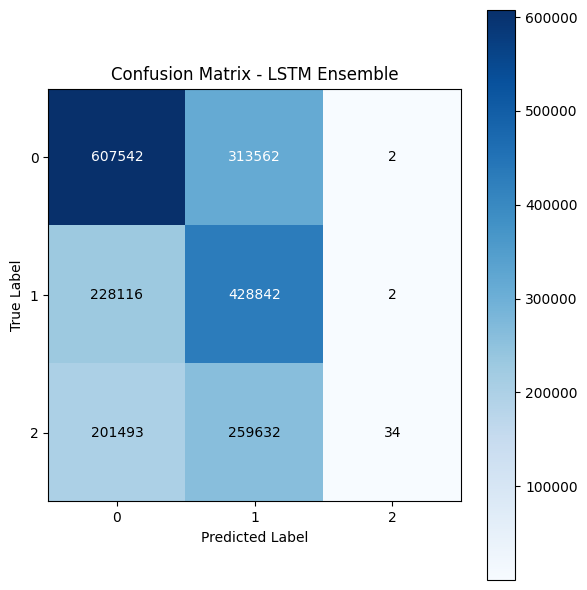

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm = confusion_matrix(Y_test.values, ensemble_lstm_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - LSTM Ensemble")
plt.colorbar()

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# 셀 값 표시
fmt = 'd'
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# 다중 클래스의 경우 True 라벨을 바이너리화
classes = np.unique(Y_test.values)
n_classes = len(classes)
Y_test_bin = label_binarize(Y_test.values, classes=classes)

fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
avg_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i])
    avg_precision[i] = average_precision_score(Y_test_bin[:, i], ensemble_lstm_probs[:, i])


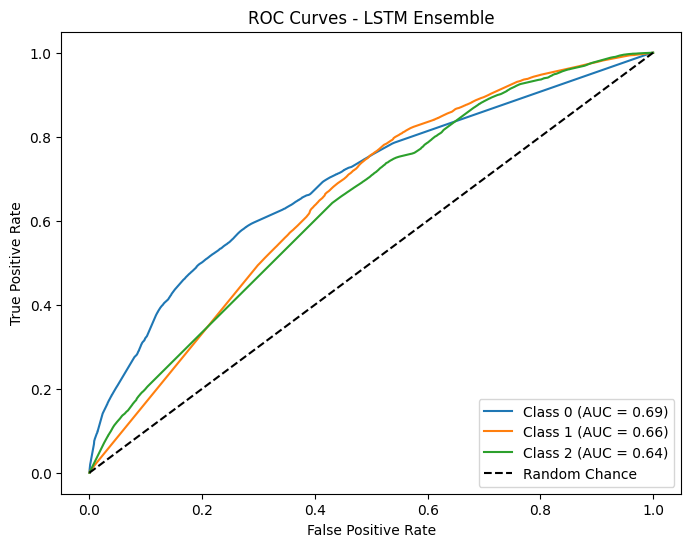

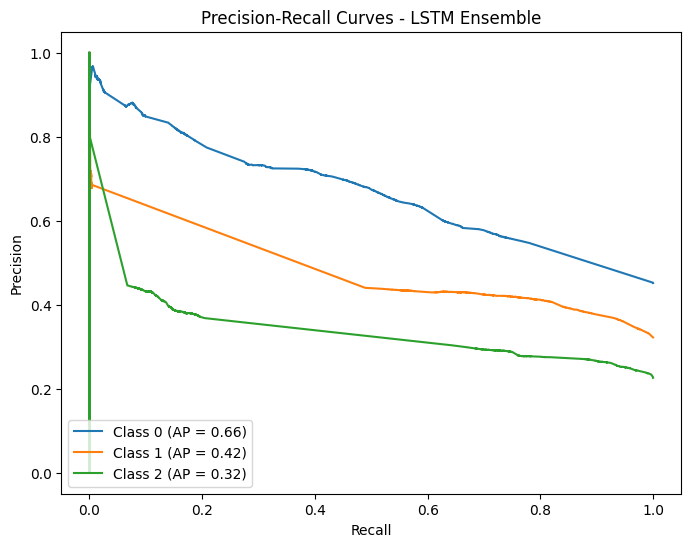

In [22]:
# ROC Curve 그리기
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - LSTM Ensemble")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve 그리기
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"Class {i} (AP = {avg_precision[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - LSTM Ensemble")
plt.legend(loc="lower left")
plt.show()

In [23]:
# Accuracy 및 Error Rate 계산
accuracy = np.sum(Y_test.values == ensemble_lstm_preds) / len(Y_test.values)
error_rate = 1 - accuracy

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.4f}")


Test Accuracy: 0.5082
Error Rate: 0.4918


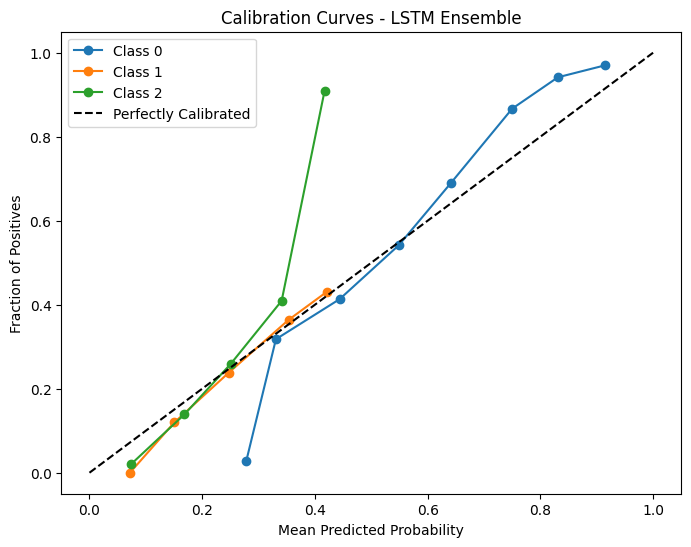

In [24]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fraction_of_positives, mean_predicted_value = calibration_curve(Y_test_bin[:, i], ensemble_lstm_probs[:, i], n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f"Class {i}")
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves - LSTM Ensemble")
plt.legend(loc="best")
plt.show()


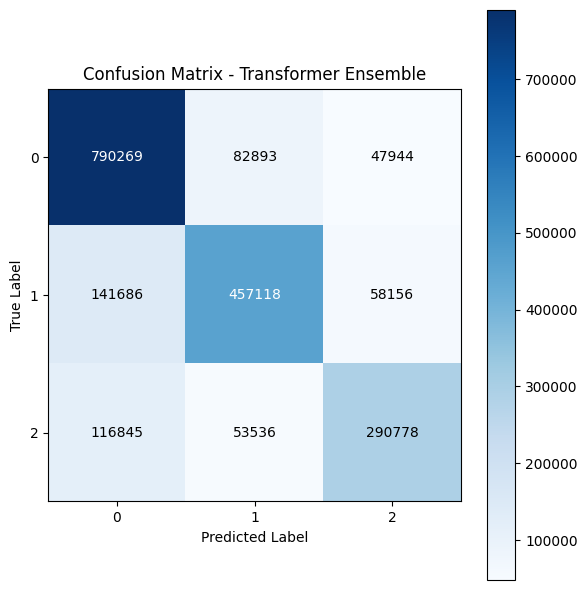

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# 혼동 행렬 계산
cm_trans = confusion_matrix(Y_test.values, ensemble_transformer_preds)

plt.figure(figsize=(6, 6))
plt.imshow(cm_trans, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Transformer Ensemble")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)

# 셀 값 표시
fmt = 'd'
thresh = cm_trans.max() / 2.0
for i in range(cm_trans.shape[0]):
    for j in range(cm_trans.shape[1]):
        plt.text(j, i, format(cm_trans[i, j], fmt),
                 ha="center", va="center",
                 color="white" if cm_trans[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


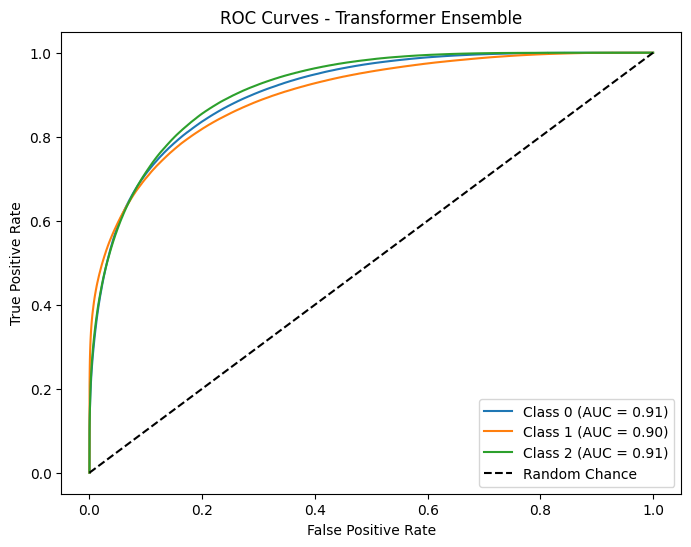

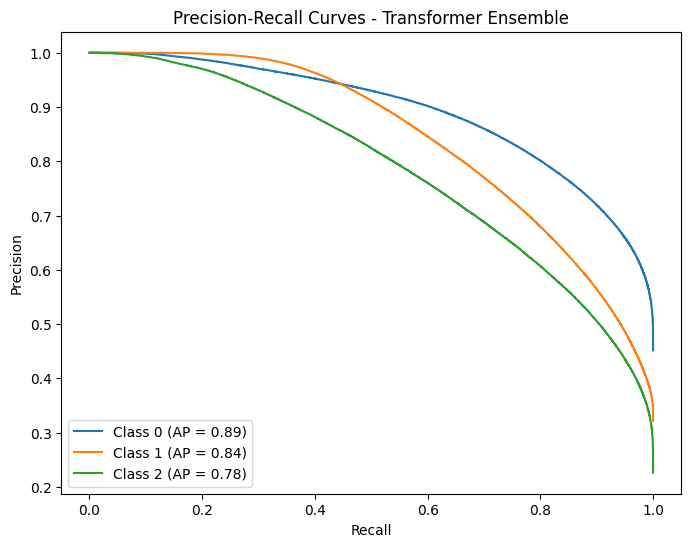

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# 다중 클래스의 경우 True 라벨을 바이너리화
classes = np.unique(Y_test.values)
n_classes = len(classes)
Y_test_bin = label_binarize(Y_test.values, classes=classes)

fpr_trans = dict()
tpr_trans = dict()
roc_auc_trans = dict()
precision_trans = dict()
recall_trans = dict()
avg_precision_trans = dict()

for i in range(n_classes):
    fpr_trans[i], tpr_trans[i], _ = roc_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
    roc_auc_trans[i] = auc(fpr_trans[i], tpr_trans[i])
    precision_trans[i], recall_trans[i], _ = precision_recall_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i])
    avg_precision_trans[i] = average_precision_score(Y_test_bin[:, i], ensemble_transformer_probs[:, i])

# ROC Curve 그리기
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr_trans[i], tpr_trans[i], label=f"Class {i} (AUC = {roc_auc_trans[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Transformer Ensemble")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve 그리기
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(recall_trans[i], precision_trans[i], label=f"Class {i} (AP = {avg_precision_trans[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves - Transformer Ensemble")
plt.legend(loc="lower left")
plt.show()


In [27]:
# Accuracy 및 Error Rate 계산
accuracy_trans = np.sum(Y_test.values == ensemble_transformer_preds) / len(Y_test.values)
error_rate_trans = 1 - accuracy_trans

print(f"Transformer Test Accuracy: {accuracy_trans:.4f}")
print(f"Transformer Error Rate: {error_rate_trans:.4f}")


Transformer Test Accuracy: 0.7543
Transformer Error Rate: 0.2457


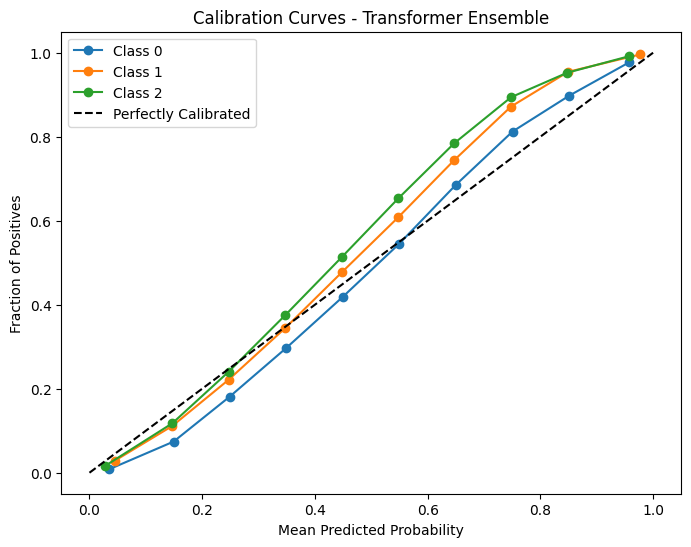

In [28]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fraction_of_positives, mean_predicted_value = calibration_curve(Y_test_bin[:, i], ensemble_transformer_probs[:, i], n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label=f"Class {i}")
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curves - Transformer Ensemble")
plt.legend(loc="best")
plt.show()
